Импорт библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from torch.nn import Softmax
from torchmetrics import Accuracy

Визуализация распределение классов

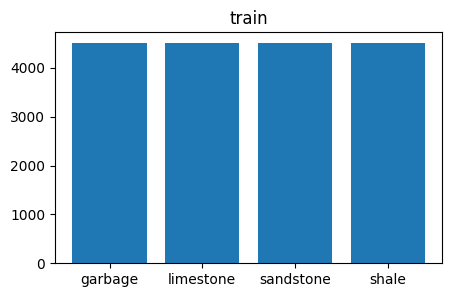

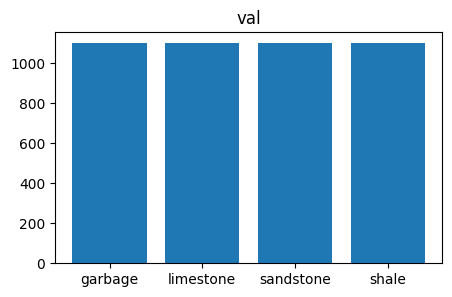

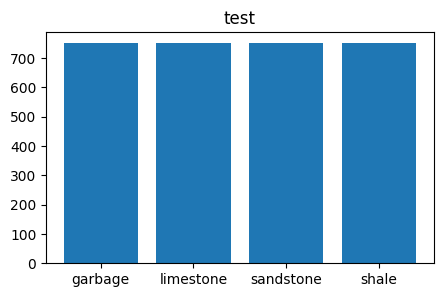

In [2]:
INPUT_DIR = "Lito Dataset"
modes = ['train', 'val', 'test']
classes = ['garbage', 'limestone', 'sandstone', 'shale']

for mode in modes:
    di = {}
    for clss in classes:
        path = os.path.join(INPUT_DIR, mode, clss)
        di[clss] = len(os.listdir(path))
    
    plt.figure(figsize=(5, 3))
    plt.bar(di.keys(), di.values())
    plt.title(mode)
    plt.show()

Отображение картинок

In [3]:
di = {}
for clss in classes:
    path = os.path.join(INPUT_DIR, 'train', clss)
    file_names = [f'{path}/{name}' for name in os.listdir(path)]
    di[clss] = file_names

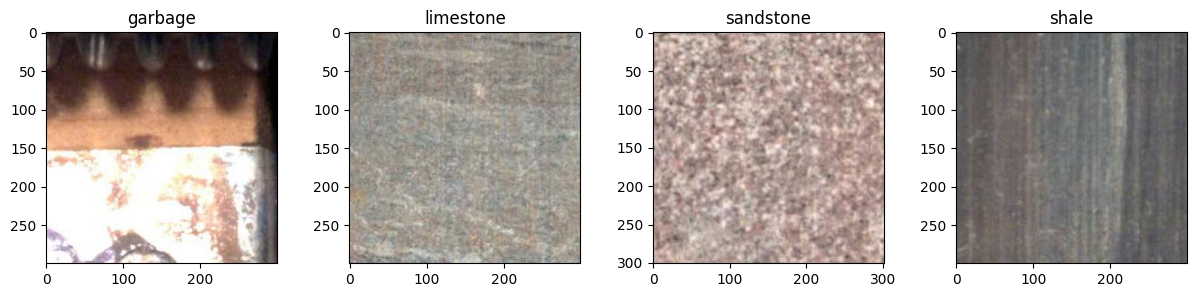

In [4]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 3))

for clss, ax in zip(di, axes):
    image_path = np.random.choice(di[clss])
    image = Image.open(image_path)
    ax.imshow(image)
    ax.set_title(clss)

Подготовка данных

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [6]:
train_dir = f"{INPUT_DIR}/train"
val_dir = f"{INPUT_DIR}/val"
test_dir = f"{INPUT_DIR}/test"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [7]:
batch_size = 100

train_dataloader = DataLoader(train_dataset, batch_size=batch_size , shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size , shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size , shuffle=True)

Создание архитектуры нейронной сети

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # 64x64

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # 32x32

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # 16x16

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*16*16, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=64, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.classifier(x)
        return x

Создание обучающего цикла

In [9]:
def train_epoch(model, train_dataloader, loss_fn, optimizer, device):
    model.train()
    batch_losses = []
    for x_b, y_b in tqdm(train_dataloader):
        x_b, y_b = x_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        y_pred = model(x_b)
        loss = loss_fn(y_pred, y_b)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    return batch_losses

def val_epoch(model, val_dataloader, loss_fn, device):
    model.eval()
    batch_losses = []
    with torch.no_grad():
        for x_b, y_b in tqdm(val_dataloader):
            x_b, y_b = x_b.to(device), y_b.to(device)
            y_pred = model(x_b)
            loss = loss_fn(y_pred, y_b)
            batch_losses.append(loss.item())
    return batch_losses

def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs, device):
    model.to(device)
    train_epoch_losses = []
    val_epoch_losses = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device)
        val_loss = val_epoch(model, val_dataloader, loss_fn, device)
        print(f'val_loss={np.mean(val_loss)}')
        train_epoch_losses.append(train_loss)
        val_epoch_losses.append(val_loss)
    return model, train_epoch_losses, val_epoch_losses

Обучение

In [10]:
model = SimpleCNN()
optimizer = torch.optim.Adam(params=model.parameters())
loss_fn = nn.CrossEntropyLoss()
n_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
model, train_epoch_losses, val_epoch_losses = train(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs, device)

100%|██████████| 44/44 [00:07<00:00,  5.56it/s]


val_loss=0.2790165235373107


100%|██████████| 44/44 [00:07<00:00,  5.53it/s]


val_loss=0.18960771963677622


100%|██████████| 44/44 [00:08<00:00,  5.48it/s]


val_loss=0.20863665504889053


100%|██████████| 44/44 [00:07<00:00,  5.56it/s]


val_loss=0.18630937867882577


100%|██████████| 44/44 [00:08<00:00,  5.48it/s]


val_loss=0.1661331489343535


100%|██████████| 44/44 [00:07<00:00,  5.50it/s]


val_loss=0.13941276920112697


100%|██████████| 44/44 [00:08<00:00,  5.50it/s]


val_loss=0.10702217636968601


100%|██████████| 44/44 [00:08<00:00,  5.46it/s]


val_loss=0.12219931786371903


100%|██████████| 44/44 [00:07<00:00,  5.57it/s]


val_loss=0.12995405520566486


100%|██████████| 44/44 [00:08<00:00,  5.43it/s]

val_loss=0.10149972267787565


Изменение ошибки при первом проходе

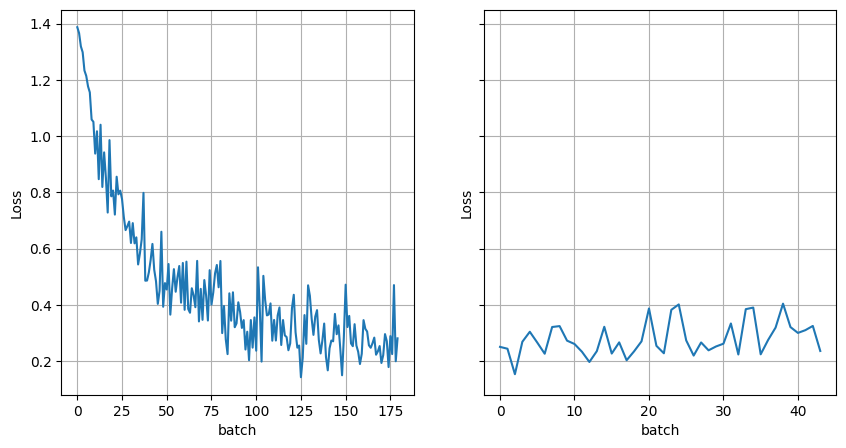

In [12]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)
axes[0].plot(train_epoch_losses[0])
axes[1].plot(val_epoch_losses[0])
for ax in axes:
    ax.grid()
    ax.set_ylabel('Loss')
    ax.set_xlabel('batch')

Изменение ошибки на на эпохах

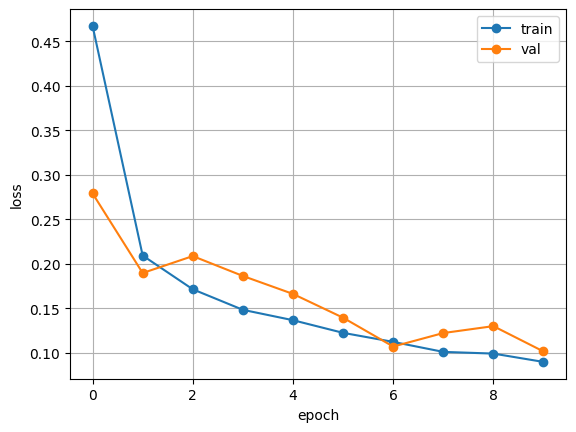

In [13]:
train_loss = [np.mean(l) for l in train_epoch_losses]
val_loss = [np.mean(l) for l in val_epoch_losses]
plt.plot(range(n_epochs), train_loss, marker='o', label='train')
plt.plot(range(n_epochs), val_loss, marker='o', label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

Оценка на тестовой выборке

In [31]:
def calc_metric(metric, model, val_dataloader, device):
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []
    sf = nn.Softmax(dim=1)
    with torch.no_grad():
        for x_b, y_b in tqdm(val_dataloader):
            x_b, y_b = x_b.to(device), y_b.to(device)
            logits = model(x_b)
            probs = sf(logits)
            y_true.append(y_b)
            y_pred.append(probs)
    y_true = torch.concat(y_true)
    y_pred = torch.concat(y_pred)
    result = metric(y_pred, y_true)
    return result, y_true, y_pred

In [35]:
metric = Accuracy(task='multiclass', num_classes=4, average='none').to(device)

acc, y_true, y_pred = calc_metric(metric, model, test_dataloader, device)

100%|██████████| 30/30 [00:05<00:00,  5.50it/s]


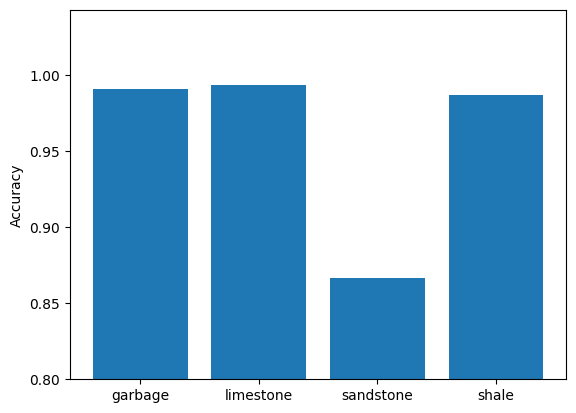

In [36]:
plt.bar(classes, acc.cpu())
plt.ylabel('Accuracy')
plt.ylim([0.8, None])
plt.show()

In [37]:
torch.save(model.state_dict(), 'SimpleCNN.pt')

In [51]:
def usage(model, transform, image_path, device, classes):
    model.to(device)
    model.eval()

    image = Image.open(image_path)
    plt.imshow(image)
    
    with torch.no_grad():
        x = transform(image).to(device).unsqueeze(0)
        logits = model(x)
        sf = nn.Softmax(dim=1)
        probs = sf(logits)
        print('predictions:')
        for clss, prob in zip(classes, probs[0]):
            print(f'\t{clss} prob = {prob}')
        plt.show()

real_class: garbage
predictions:
	garbage prob = 0.9999984502792358
	limestone prob = 3.426393746508438e-08
	sandstone prob = 3.5433593836842192e-09
	shale prob = 1.5672729887228343e-06


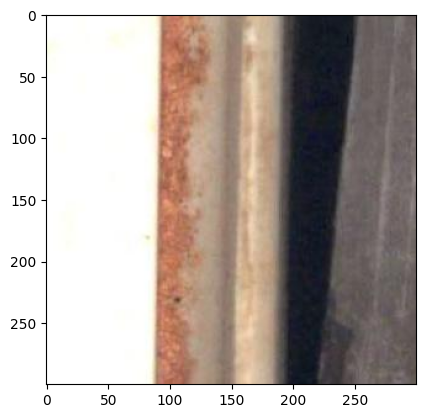

real_class: sandstone
predictions:
	garbage prob = 1.257207031812868e-07
	limestone prob = 0.0040960111655294895
	sandstone prob = 0.9947012662887573
	shale prob = 0.001202598330564797


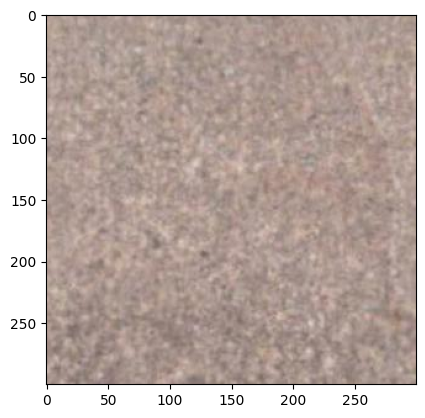

real_class: sandstone
predictions:
	garbage prob = 5.927706242525588e-13
	limestone prob = 7.045407590666741e-10
	sandstone prob = 1.0
	shale prob = 5.677973646811552e-09


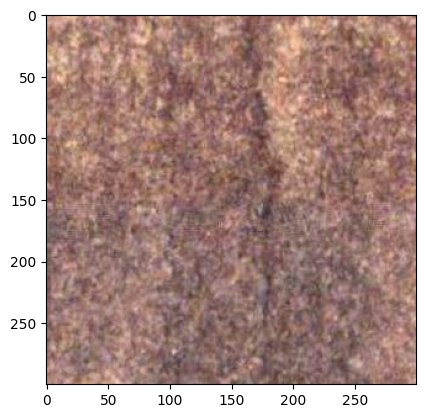

real_class: garbage
predictions:
	garbage prob = 0.9151259064674377
	limestone prob = 0.084123395383358
	sandstone prob = 4.9522470362717286e-05
	shale prob = 0.0007011426496319473


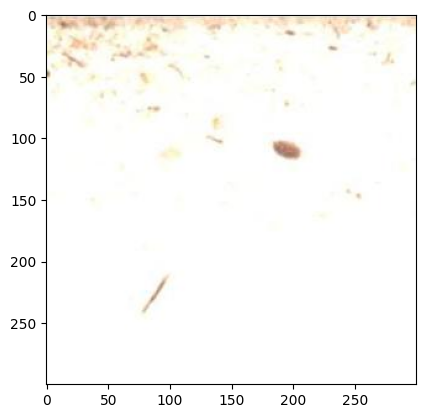

real_class: sandstone
predictions:
	garbage prob = 1.0737790864800978e-11
	limestone prob = 4.616317994532437e-09
	sandstone prob = 1.0
	shale prob = 4.92913976302134e-09


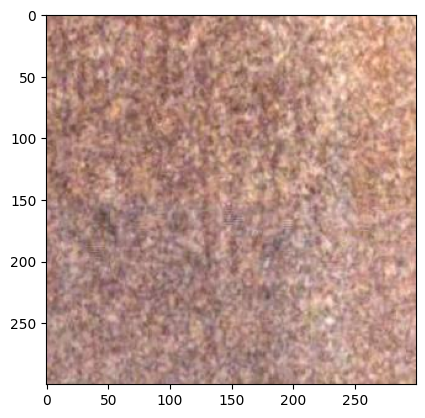

real_class: shale
predictions:
	garbage prob = 8.891392644727603e-05
	limestone prob = 1.8506242371874038e-10
	sandstone prob = 2.60635147242283e-06
	shale prob = 0.999908447265625


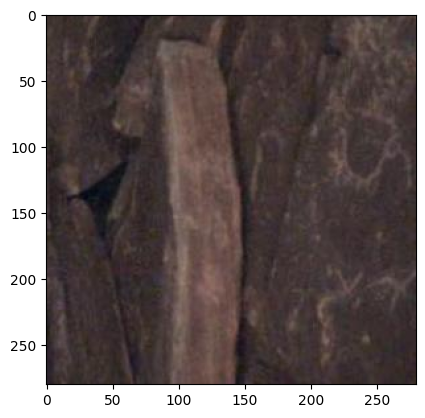

real_class: sandstone
predictions:
	garbage prob = 2.0494771035828308e-07
	limestone prob = 0.0006820709677413106
	sandstone prob = 0.9933937191963196
	shale prob = 0.005923994816839695


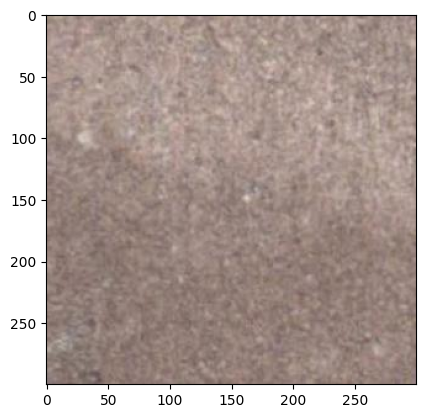

real_class: sandstone
predictions:
	garbage prob = 5.8522501081292866e-12
	limestone prob = 5.4431508189622946e-09
	sandstone prob = 1.0
	shale prob = 1.0341146827741454e-09


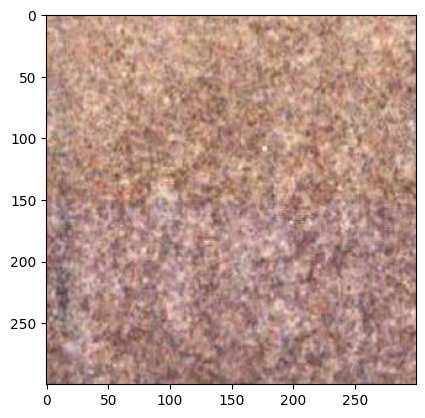

real_class: sandstone
predictions:
	garbage prob = 1.4164112049040722e-13
	limestone prob = 1.7700962917643892e-10
	sandstone prob = 0.9999998807907104
	shale prob = 1.0305634390306295e-07


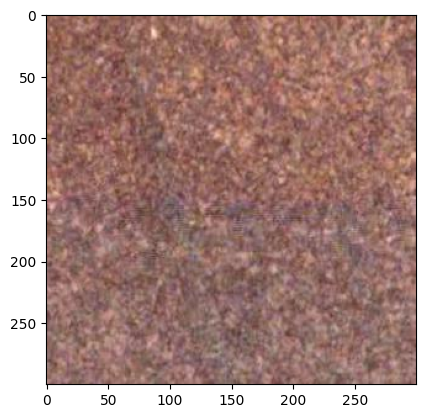

real_class: shale
predictions:
	garbage prob = 3.471386662567966e-05
	limestone prob = 8.304131711156515e-07
	sandstone prob = 0.0005533789517357945
	shale prob = 0.9994111061096191


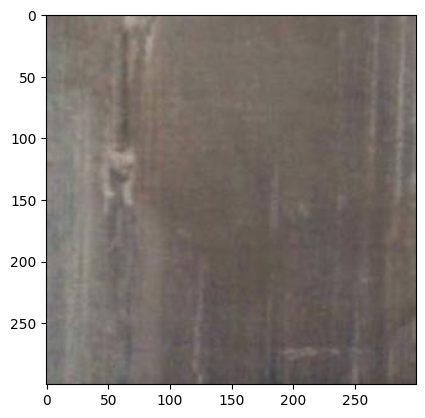

In [52]:
for _ in range(10):
    clss = np.random.choice(classes)
    path = os.path.join(INPUT_DIR, 'test', clss)
    images = [os.path.join(path, image_name) for image_name in os.listdir(path)]
    image_path = random.choice(images)
    print(f'real_class: {clss}')
    usage(model, transform, image_path, device, classes)